In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pathlib

import tensorflow as tf
from keras import layers
from keras.models import Sequential

2023-09-30 16:13:45.906775: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_dir = pathlib.Path('/mnt/c/Users/victor.m.silva/Documents/www/sptech/dataset_pca_50/train')
data_test_dir = pathlib.Path('/mnt/c/Users/victor.m.silva/Documents/www/sptech/dataset_pca_50/test')
data_dir

PosixPath('/mnt/c/Users/victor.m.silva/Documents/www/sptech/dataset_pca_50/train')

In [3]:
image_count = len(list(data_dir.glob("**/*")))
print(image_count)

1839


### Visualizing one image per class

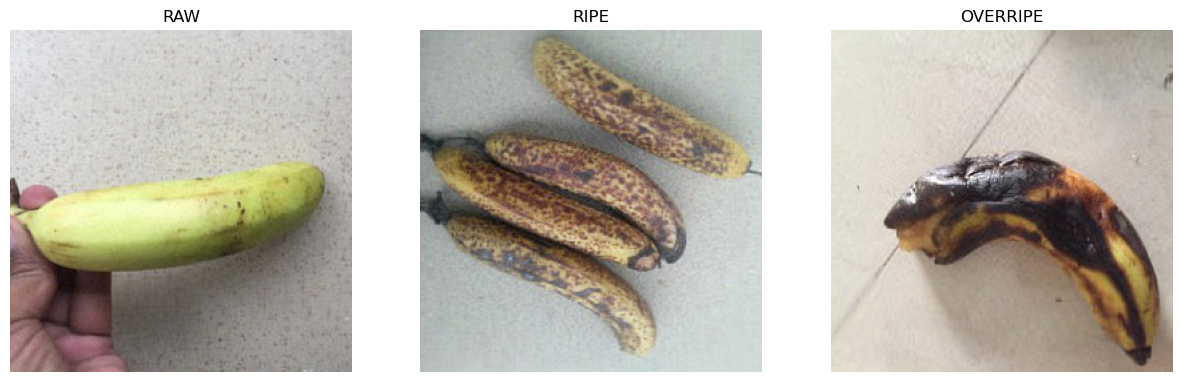

In [4]:
raw = str(list(data_dir.glob("raw/*.jpg"))[10])
ripe = str(list(data_dir.glob("ripe/*.jpg"))[10])
overripe = str(list(data_dir.glob("overripe/*.jpg"))[10])

ax, sub = plt.subplots(1, 3, figsize=(15, 15))
sub[0].set_title("RAW")
sub[0].axis("off")
sub[0].imshow(cv.cvtColor(cv.imread(raw), cv.COLOR_BGR2RGB))

sub[1].set_title("RIPE")
sub[1].axis("off")
sub[1].imshow(cv.cvtColor(cv.imread(ripe), cv.COLOR_BGR2RGB))

sub[2].set_title("OVERRIPE")
sub[2].axis("off")
sub[2].imshow(cv.cvtColor(cv.imread(overripe), cv.COLOR_BGR2RGB))

## Dividing the dataset

In [6]:
batch_size = 32
img_height = 256
img_width = 256

In [7]:
(train_ds, val_ds) = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="both",
    seed=42,
    batch_size=batch_size,
)

Found 1836 files belonging to 3 classes.
Using 1469 files for training.
Using 367 files for validation.


2023-09-30 16:14:18.150069: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [76]:
# train_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="training",
#     seed=42,
#     batch_size=batch_size,
# )

Found 1836 files belonging to 3 classes.
Using 1469 files for training.


In [77]:
# val_ds = tf.keras.utils.image_dataset_from_directory(
#     data_dir,
#     validation_split=0.2,
#     subset="validation",
#     seed=42,
#     batch_size=batch_size,
# )

Found 1836 files belonging to 3 classes.
Using 367 files for validation.


In [8]:
class_names = train_ds.class_names
print(class_names)

['overripe', 'raw', 'ripe']


2023-09-30 16:14:25.878790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1469]
	 [[{{node Placeholder/_4}}]]
2023-09-30 16:14:25.879265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1469]
	 [[{{node Placeholder/_0}}]]


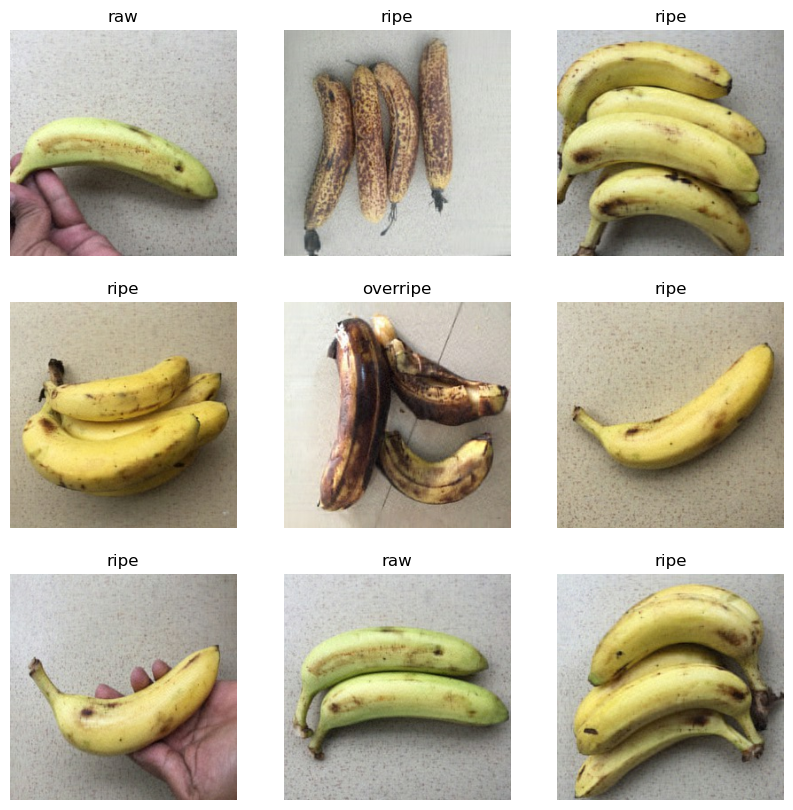

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Data augmentation

In [10]:
num_classes = len(class_names)

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2, fill_mode="constant"),
    layers.RandomZoom(0.2),
])

2023-09-30 16:14:42.785444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1469]
	 [[{{node Placeholder/_4}}]]
2023-09-30 16:14:42.785860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1469]
	 [[{{node Placeholder/_0}}]]


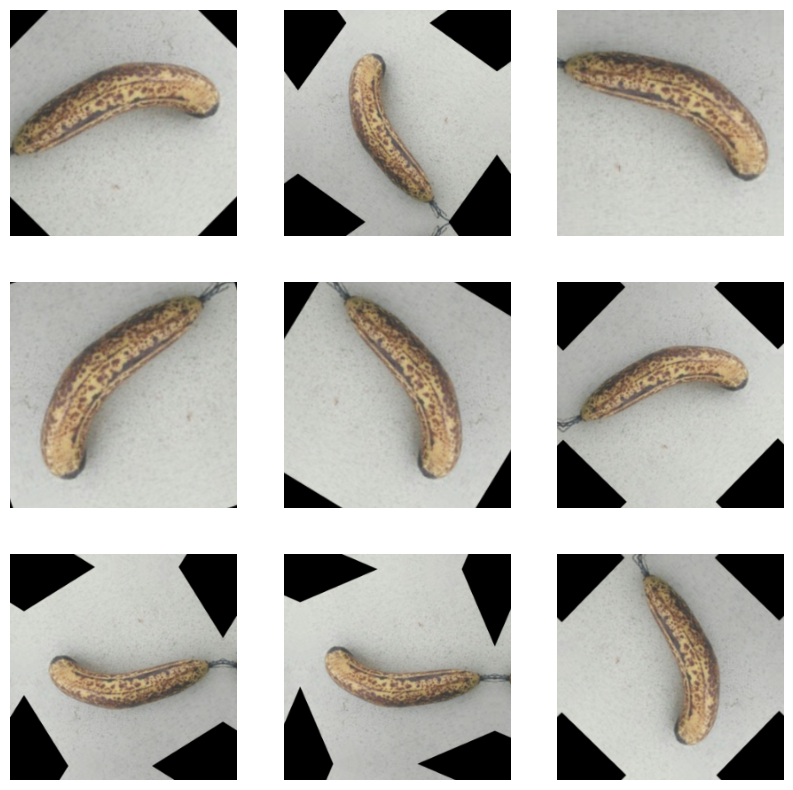

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Model

In [13]:
model = Sequential(
    [
        data_augmentation,
        layers.Rescaling(1.0 / 255, input_shape=(img_height, img_width, 3)),
        layers.Conv2D(64, 11, padding="same", activation="relu"),
        layers.Conv2D(64, 5, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.Conv2D(128, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Conv2D(256, 3, padding="same", activation="relu"),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(32, activation="relu"),
        layers.Dense(num_classes, name="outputs"),
    ]
)

In [14]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [ ]:
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/5


2023-09-30 16:52:31.420047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1469]
	 [[{{node Placeholder/_4}}]]
2023-09-30 16:52:31.420309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1469]
	 [[{{node Placeholder/_4}}]]


46/46 [==============================] - ETA: 0s - loss: 1.1795 - accuracy: 0.6338 

2023-09-30 17:06:22.944241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [367]
	 [[{{node Placeholder/_4}}]]
2023-09-30 17:06:22.945384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [367]
	 [[{{node Placeholder/_4}}]]


46/46 [==============================] - 881s 19s/step - loss: 1.1795 - accuracy: 0.6338 - val_loss: 0.8268 - val_accuracy: 0.7057
Epoch 2/5
38/46 [=======================>......] - ETA: 2:27 - loss: 0.8895 - accuracy: 0.6530

In [71]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 128)     73856     
                                                      

## Visualize Training Results

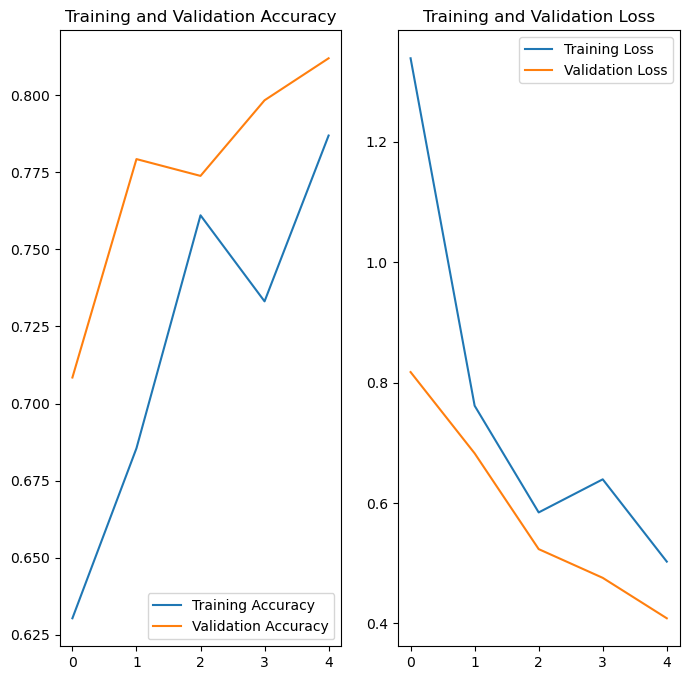

In [47]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [57]:
pre = tf.keras.metrics.Precision()
re = tf.keras.metrics.Recall()
acc = tf.keras.metrics.Accuracy()

test = tf.keras.utils.image_dataset_from_directory(data_test_dir)

for batch in test.as_numpy_iterator():
    X, y = batch
    probabilities = model.predict(X)
    classes = np.argmax(probabilities, axis=-1)
    pre.update_state(y, classes)
    re.update_state(y, classes)
    acc.update_state(y, classes)

print(f"Precision: {pre.result().numpy()}")
print(f"Recall: {re.result().numpy()}")
print(f"Accuracy: {acc.result().numpy()}")

Found 120 files belonging to 3 classes.


2023-09-29 20:07:49.121512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]
2023-09-29 20:07:49.121901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [120]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 1s 1s/step
Precision: 0.988095223903656
Recall: 0.988095223903656
Accuracy: 0.8583333492279053


## Test

### Defining helper function

In [58]:
def predict_image_from_path(img_path):
    img = tf.keras.utils.load_img(
        img_path, target_size=(img_height, img_width)
    )

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch

    predictions = model.predict(img_array, verbose=False)
    score = tf.nn.softmax(predictions[0])

    res = class_names[np.argmax(score)]
    percentage = 100 * np.max(score)
    print(
        "This image most likely belongs to {} with a {:.2f} percent confidence."
        .format(res, percentage)
    )

    return res, percentage

### One Image

This image most likely belongs to ripe with a 61.88 percent confidence.


(-0.5, 255.5, 255.5, -0.5)

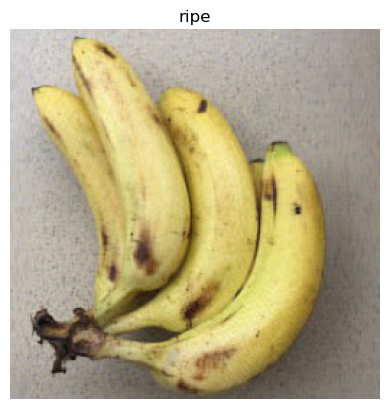

In [59]:
img_ripe = str(list(data_test_dir.glob("ripe/*.jpg"))[10])

res = predict_image_from_path(img_ripe)

plt.imshow(cv.cvtColor(cv.imread(img_ripe), cv.COLOR_BGR2RGB))
plt.title(res[0])
plt.axis("off")

### One directory of images

#### RAW

In [66]:
expected_class = "raw"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0
wrong_list = []

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1
    else:
        wrong_list.append(img_path.name)

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)
print(wrong_list)

This image most likely belongs to ripe with a 91.89 percent confidence.
This image most likely belongs to ripe with a 93.24 percent confidence.
This image most likely belongs to ripe with a 81.31 percent confidence.
This image most likely belongs to ripe with a 67.06 percent confidence.
This image most likely belongs to ripe with a 67.62 percent confidence.
This image most likely belongs to ripe with a 67.75 percent confidence.
This image most likely belongs to ripe with a 67.70 percent confidence.
This image most likely belongs to ripe with a 68.53 percent confidence.
This image most likely belongs to ripe with a 66.80 percent confidence.
This image most likely belongs to ripe with a 56.75 percent confidence.
This image most likely belongs to ripe with a 70.40 percent confidence.
This image most likely belongs to ripe with a 72.69 percent confidence.
This image most likely belongs to ripe with a 67.76 percent confidence.
This image most likely belongs to ripe with a 50.84 percent conf

#### RIPE

In [67]:
expected_class = "ripe"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0
wrong_list = []

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1
    else:
        wrong_list.append(img_path.name)

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)
print(wrong_list)

This image most likely belongs to ripe with a 75.24 percent confidence.
This image most likely belongs to ripe with a 84.74 percent confidence.
This image most likely belongs to ripe with a 93.10 percent confidence.
This image most likely belongs to ripe with a 98.51 percent confidence.
This image most likely belongs to overripe with a 51.75 percent confidence.
This image most likely belongs to ripe with a 98.41 percent confidence.
This image most likely belongs to ripe with a 97.11 percent confidence.
This image most likely belongs to ripe with a 98.29 percent confidence.
This image most likely belongs to ripe with a 83.61 percent confidence.
This image most likely belongs to ripe with a 90.07 percent confidence.
This image most likely belongs to ripe with a 61.88 percent confidence.
This image most likely belongs to ripe with a 81.49 percent confidence.
This image most likely belongs to ripe with a 78.29 percent confidence.
This image most likely belongs to ripe with a 85.33 percent 

#### OVERRIPE

In [69]:
expected_class = "overripe"

imgs = list(data_test_dir.glob(f"{expected_class}/*.jpg"))

total_size = len(imgs)
total_right = 0
wrong_list = []

for img_path in imgs:
    res, percentage = predict_image_from_path(img_path)

    if res == expected_class:
        total_right += 1
    else:
        wrong_list.append(img_path.name)

print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)
print(wrong_list)

This image most likely belongs to overripe with a 96.60 percent confidence.
This image most likely belongs to overripe with a 93.51 percent confidence.
This image most likely belongs to overripe with a 95.96 percent confidence.
This image most likely belongs to overripe with a 96.57 percent confidence.
This image most likely belongs to overripe with a 98.89 percent confidence.
This image most likely belongs to overripe with a 96.22 percent confidence.
This image most likely belongs to overripe with a 98.93 percent confidence.
This image most likely belongs to overripe with a 98.47 percent confidence.
This image most likely belongs to overripe with a 96.92 percent confidence.
This image most likely belongs to overripe with a 97.89 percent confidence.
This image most likely belongs to overripe with a 95.78 percent confidence.
This image most likely belongs to overripe with a 85.45 percent confidence.
This image most likely belongs to overripe with a 93.52 percent confidence.
This image m

### Three directories of images

In [57]:
raw_right = 0
ripe_right = 0
overripe_right = 0

for img_class in os.listdir(data_test_dir):
    for img in os.listdir(os.path.join(data_test_dir, img_class)):
        img_path = os.path.join(data_test_dir, img_class, img)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "raw" and res == "raw":
            raw_right += 1
        elif img_class == "ripe" and res == "ripe":
            overripe_right += 1
        elif img_class == "overripe" and res == "overripe":
            ripe_right += 1

    print()

raw_size = len(os.listdir(os.path.join(data_test_dir, "raw")))
overripe_size = len(os.listdir(os.path.join(data_test_dir, "ripe")))
ripe_size = len(os.listdir(os.path.join(data_test_dir, "overripe")))
total_size = raw_size + overripe_size + ripe_size
total_right = raw_right + overripe_right + ripe_right

print(
    f"Result raw: got { raw_right }/{ raw_size } right, which means { round(raw_right * 100 / raw_size, 2) }%"
)
print(
    f"Result overripe: got { overripe_right }/{ overripe_size } right, which means { round(overripe_right * 100 / overripe_size, 2) }%"
)
print(
    f"Result ripe: got { ripe_right }/{ ripe_size } right, which means { round(ripe_right * 100 / ripe_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

This image most likely belongs to overripe with a 91.33 percent confidence.
This image most likely belongs to overripe with a 86.96 percent confidence.
This image most likely belongs to overripe with a 90.13 percent confidence.
This image most likely belongs to overripe with a 93.67 percent confidence.
This image most likely belongs to overripe with a 91.36 percent confidence.
This image most likely belongs to overripe with a 93.11 percent confidence.
This image most likely belongs to overripe with a 95.78 percent confidence.
This image most likely belongs to overripe with a 84.38 percent confidence.
This image most likely belongs to overripe with a 77.82 percent confidence.
This image most likely belongs to overripe with a 95.63 percent confidence.
This image most likely belongs to overripe with a 76.77 percent confidence.
This image most likely belongs to overripe with a 82.01 percent confidence.
This image most likely belongs to overripe with a 92.36 percent confidence.
This image m

### Testing with images taken by me

In [70]:
raw_right = 0
ripe_right = 0
overripe_right = 0

imgs_taken_by_me_path = "/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/taken_by_me/dataset_pca/"

for img_class in os.listdir(imgs_taken_by_me_path):
    for img in os.listdir(os.path.join(imgs_taken_by_me_path, img_class)):
        img_path = os.path.join(imgs_taken_by_me_path, img_class, img)
        # print(img_path)

        res, percentage = predict_image_from_path(img_path)

        if img_class == "raw" and res == "raw":
            raw_right += 1
        elif img_class == "ripe" and res == "ripe":
            overripe_right += 1
        elif img_class == "overripe" and res == "overripe":
            ripe_right += 1
    print()

raw_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "raw")))
overripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "ripe")))
ripe_size = len(os.listdir(os.path.join(imgs_taken_by_me_path, "overripe")))
total_size = raw_size + overripe_size + ripe_size
total_right = raw_right + overripe_right + ripe_right

print(
    f"Result raw: got { raw_right }/{ raw_size } right, which means { round(raw_right * 100 / raw_size, 2) }%"
)
print(
    f"Result overripe: got { overripe_right }/{ overripe_size } right, which means { round(overripe_right * 100 / overripe_size, 2) }%"
)
print(
    f"Result ripe: got { ripe_right }/{ ripe_size } right, which means { round(ripe_right * 100 / ripe_size, 2) }%"
)
print()
print(
    f"Result overall: got { total_right }/{ total_size } right, which means { round( total_right * 100 / total_size, 2) }%"
)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/csantana/Dev/TCC/datasets/banana_stages_classifier/taken_by_me/dataset_pca/'

## Save

In [52]:
model.save('models/banana_stages_classifier.h5')


In [53]:
loaded_model = tf.keras.models.load_model('models/banana_stages_classifier.h5')

In [54]:
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)       